# Метаклассы и создание экземпляра

> “Metaclasses are deeper magic than 99% of users should ever worry about. If you wonder whether you need them, you don’t (the people who actually need them know with certainty that they need them, and don’t need an explanation about why).”

                                                                                                   — Tim Peters

## Создание нового экземпляра

Вы уже знаете, что конструктор в питоне объявляется магическим методом `__init__(self, ...) -> None`. Но в момент вызова этого метода объект уже создан:

In [ ]:
class A:
    def __init__(self):
        print("Только вошли в конструктор, а тут уже есть self =", self)
        
A()

Но что если мы хотим изменить объект до его создания?

### Классы

https://habr.com/ru/post/114585/

https://refactoring.guru/ru/design-patterns/abstract-factory

Классы в питоне - это объектные фабрики.

__Абстрактная фабрика__ — это порождающий паттерн проектирования, который позволяет создавать семейства связанных объектов, не привязываясь к конкретным классам создаваемых объектов.

__Фабрика__ - объект, создающий другие объекты, которые считаются новыми.

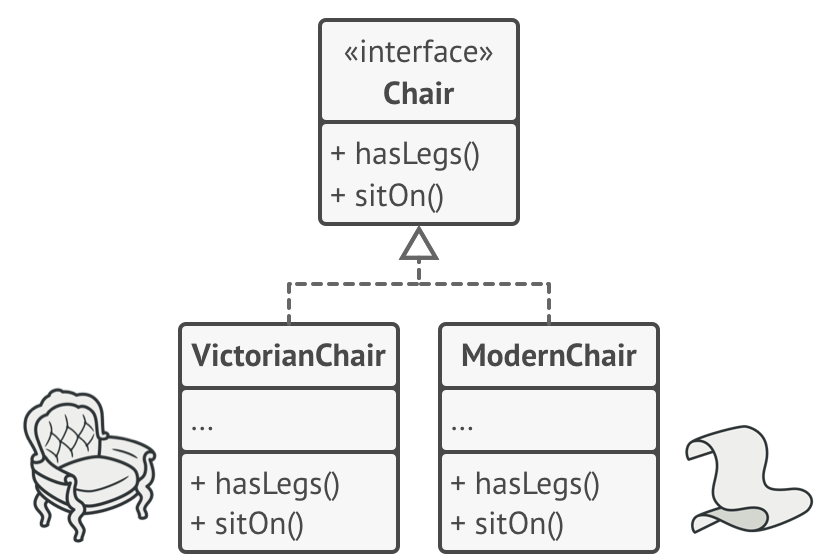

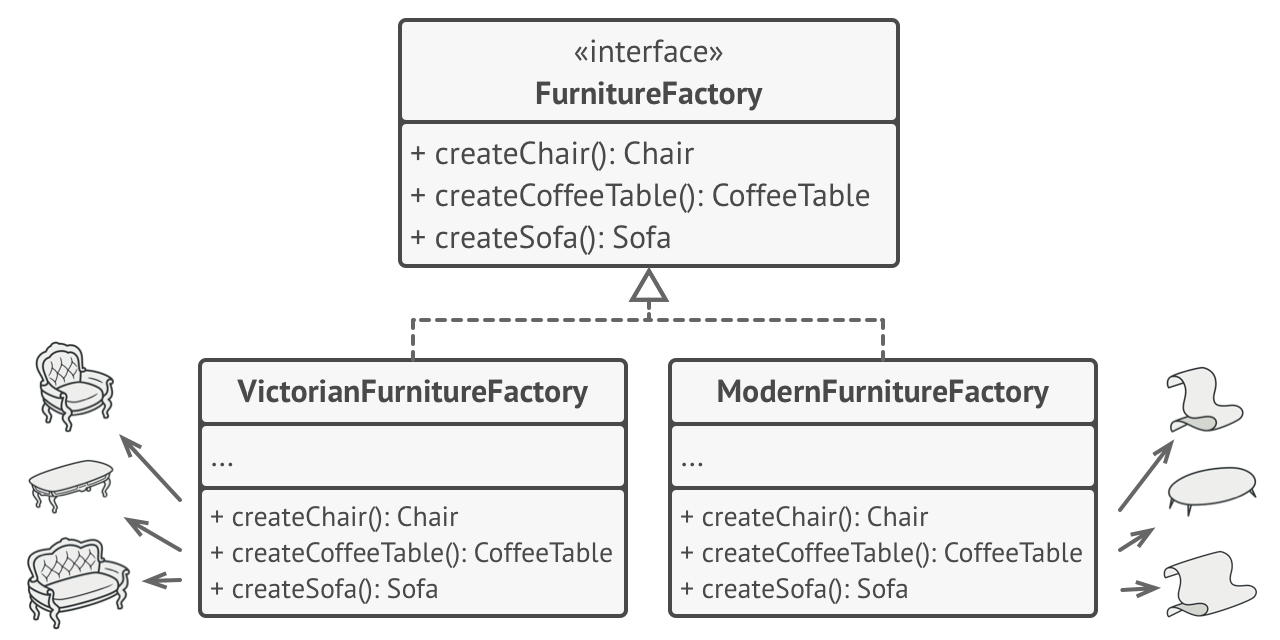

Инстанцирование объекта происходит в 2 этапа:

1. Вызывается классовый метод `__new__(cls, *args, **kwargs) -> object`, который, хоть и не объявляется `@classmethod`, но является таким;
2. У объекта, возвращенного в предыдущем пункте, вызывается метод `__init__(self, *args, **kwargs) -> None`, в котором описываются изначальные действия с объектом.

In [ ]:
class A(object):
    def __new__(cls, value):
        obj = super(A, cls).__new__(cls)
        print(f"Создался объект {obj} класса {cls} с аргументом {value}")
        return obj
    
    def __init__(self, value):
        self.val = value
        print(f"Инициализируем объект {self} с аргументом {value}")


a = A(25)

### Реализация паттерна синглтон (одиночка)

https://refactoring.guru/ru/design-patterns/singleton

__Синглтон__ - это порождающий паттерн проектирования, который гарантирует, что у класса есть только один экземпляр, и предоставляет к нему глобальную точку доступа. Т.е. при вызове конструктора такого класса должен возвращаться уже созданный однажды объект. (Новый должен вернуться только при самом первом вызове конструктора синглтона). Пример применения таких классов - класс некоторого приложения, которое не должно быть открыто дважды.

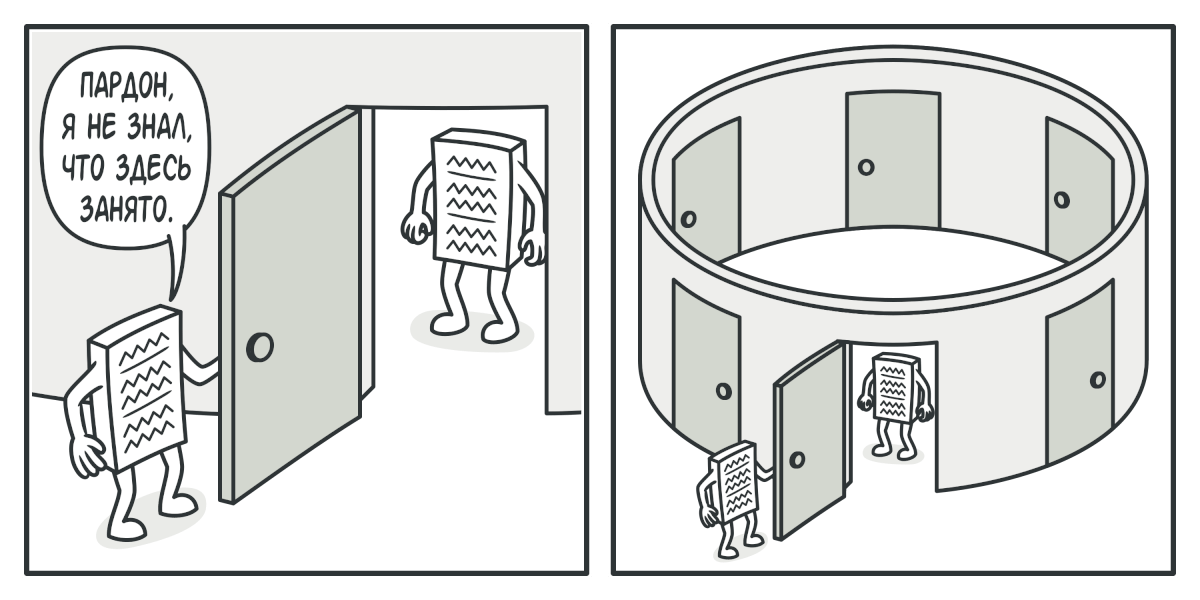

In [ ]:
class Singleton(object):
    instance = None
    
    def __new__(cls):
        if cls.instance is None:
            cls.instance = super(Singleton, cls).__new__(cls)
        return cls.instance
    
    
Singleton() is Singleton()

In [ ]:
a = Singleton()
a.x = 1
b = Singleton()
print("b.x =", b.x)
b.y = 2
print("a.y =", a.y)

## Метаклассы

В питоне всё является объектами, в том числе и сами классы. А какой тип у класса?

In [ ]:
Singleton.__class__

Тот же самый, что у базовых типов, функций, базового класса object и, соответственно, класса type:

In [ ]:
object.__class__

In [ ]:
type.__class__

object - это базовый класс, от которого наследуются абсолютно все объекты в Python 3+. type - это класс, который символизирует тип. Вся магия со словарем `__dict__` в объектах происходит именно благодаря классу type. В объектах класса object нет атрибута `__dict__`.

In [ ]:
type(3).__dict__

In [ ]:
object().__dict__

Рассмотрим отношения классов object и type. Базовым классом любого объекта является object:

In [ ]:
str.__mro__

In [ ]:
Singleton.__mro__

In [ ]:
type.__mro__

In [ ]:
object.__mro__

А вот isinstance выдает странные вещи для этих двух базовых типов:

In [ ]:
isinstance(object, type), isinstance(object, object)

In [ ]:
isinstance(type, type), isinstance(type, object)

In [ ]:
isinstance(int, object), isinstance(int, type)

In [ ]:
isinstance(Singleton, object), isinstance(Singleton, type)

Копнем чуть глубже и посмотрим на то, что из этого подкласс другого:

In [ ]:
issubclass(type, object)

In [ ]:
issubclass(object, type)

In [ ]:
issubclass(Singleton, object), issubclass(Singleton, type)

In [ ]:
issubclass(str, object), issubclass(str, type)

### Определение метакласса

Получается, что классы - это расширения базового класса __object__. А __type__ - это __метакласс__.

__Метакласс__ - это класс, экземплярами которого являются другие классы. Всё, что определено в метаклассе, доступно для классов, но недоступно для объектов. Отношение класс-метакласс получается таким же, как объект-класс.

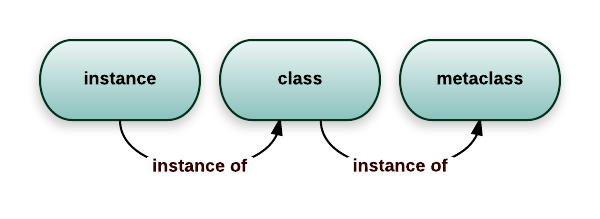

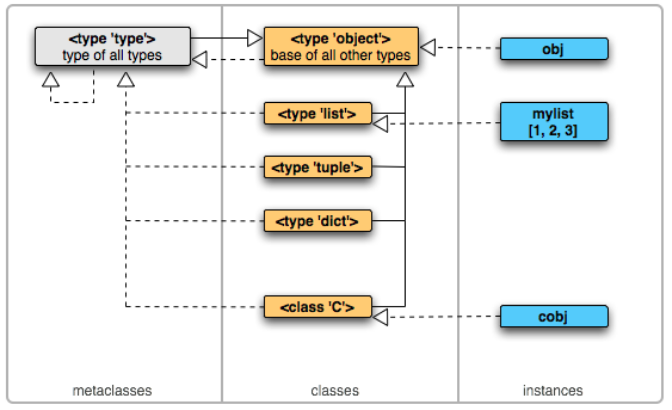

Поиск атрибутов класса происходит так же, как в объектах:

1. Поиск атрибута в `__dict__` класса;
2. Если не найден, то в `__dict__` метакласса.

In [ ]:
# метаклассы наследуются от type
class Ameta(type):
    def foo(cls):
        print("Ameta.foo")
    

class A(object, metaclass=Ameta):
    pass


A.foo()
A().foo()

Так же, как и в случае с привязкой методов к объекту класса, метод метакласса, вызванный из класса, является bound методом, а вызванный из метакласса - обычной функцией.

In [ ]:
A.foo, Ameta.foo

Но если определяем в классе свой атрибут foo, обращение из объекта будет вызывать его:

In [ ]:
class B(A):
    @classmethod
    def foo(cls):
        print("B.foo")
        
        
B.foo()
B().foo()

# Динамическое создание классов

https://proglib.io/p/metaclasses-in-python/

Есть 2 способа создать класс. Один мы уже знаем - это объявить его прямо в коде в блоке `class`. Другой способ - использовать встроенную функцию `type`.

In [ ]:
MyShinyClass = type('MyShinyClass', (), {})

print(MyShinyClass)
print(MyShinyClass())

Общий синтаксис функции type:

`type(<__name__ класса>, (<кортеж базовых классов>), {<словарь атрибутов класса>})`

In [ ]:
ShinyChild = type(
    'ShinyChild',
    (MyShinyClass,),
    {
        'true_value': True,
        'upper': lambda self, sth: sth.upper()
    }
)

print(ShinyChild().true_value)
print(ShinyChild().upper('abcd'))

## Алгоритм создания класса

Повторим, как создается объект:

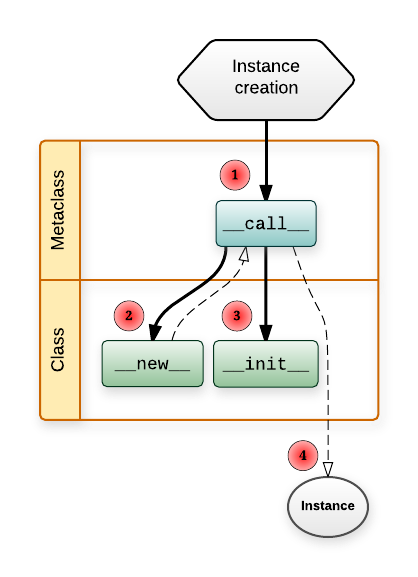

Похожим образом создается класс:

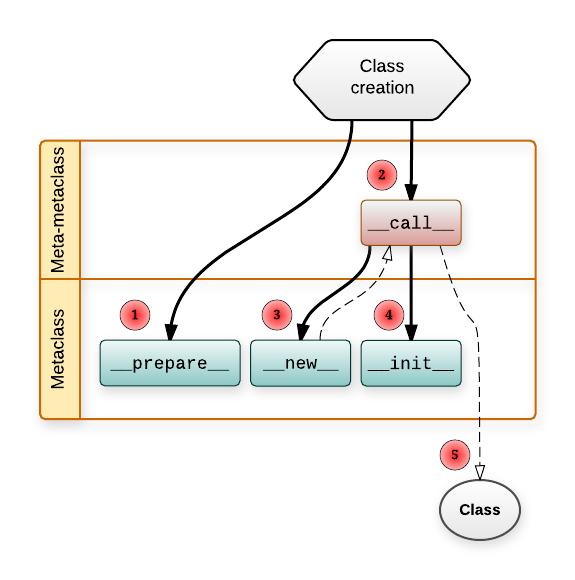

In [ ]:
class AMeta(type):
    def __new__(mcs, name, bases, classdict, **kwargs):
        cls = super().__new__(mcs, name, bases, classdict)
        print('Meta __new__', cls)
        return cls

    def __init__(cls, name, bases, classdict, **kwargs):
        print('Meta __init__', cls)
        super().__init__(name, bases, classdict, **kwargs)

    def __call__(cls):
        print('Meta __call__')
        return super().__call__()

    @classmethod
    def __prepare__(mcs, name, bases, **kwargs):
        print('Meta __prepare__', **kwargs)
        return {'b': 2, 'a': 2}


class A(metaclass=AMeta):
    a = 1

    def __new__(cls):
        self = super().__new__(cls)
        print('class __new__', self)
        return self

    def __init__(self):
        print('class __init__')

    def __call__(self):
        print('class __call__')
        pass


a = A()
print()
print("Объект создан, теперь обратимся к атрибутам:")
print(a.a)
print(a.b)

print()
print("А теперь создадим еще один класс (не объект):")
Another = AMeta('Test', (), {}, kw1=1, kw2=2)

## Пользовательские метаклассы

Напишем метакласс, который позволяет использовать нотацию нижнего_подчеркивания для доступа к атрибутам, заданным camelCase'ом.

In [ ]:
import re


class CamelToUnderscoreMeta(type):
    def __new__(mcs, name, mro, attrs):
        """
          Возвращает класс с переопределенными названиями атрибутов.
        """
        def camel2undrscr(s):
            """Преобразует все заглавные буквы в строке в _ и маленькую букву"""
            return re.sub('([A-Z])', lambda pattern: '_' + pattern.group(1).lower(), s)

        # преобразуем все атрибуты, кроме магических
        new_attrs = {}
        for name, val in attrs.items():
            if not name.startswith('__'):
                new_attrs[camel2undrscr(name)] = val
            else:
                new_attrs[name] = val

        # возвращаем класс, прокидывая имя и родителей
        return super(CamelToUnderscoreMeta, mcs).__new__(mcs, name, mro, new_attrs)

In [ ]:
class Foo(metaclass=CamelToUnderscoreMeta):
    someCodeFromCLib = 12345
    
    
print(Foo().some_code_from_c_lib)
print(Foo().someCodeFromCLib)

### Метакласс-синглтон

https://habr.com/ru/post/114587/

Определять в метаклассе можно не только метод `__new__`, но и любые другие.

In [ ]:
class SingletonMeta(type):
    def __init__(cls, *args, **kw):
        cls.instance = None
        
    def __call__(cls, *args, **kw):
        if cls.instance is None:
            cls.instance = super(SingletonMeta, cls).__call__(*args, **kw)
        return cls.instance
    

class SingletonFromMeta(metaclass=SingletonMeta):
    def __init__(self, default):
        self.default = default


a = SingletonFromMeta(5)
a.x = 1
print(SingletonFromMeta(88).default)
print(SingletonFromMeta().x)

### Пример из популярных библиотек

В Django есть собственная ORM - обертка над базой данных. Классы там переопределены так, чтобы при определенных условиях брать как названия, так и значения атрибутов из таблицы в базе данных, к которой подключается серверное приложение. Вот пример:

In [ ]:
class Person(models.Model):
    name = models.CharField(max_length=30)
    age = models.IntegerField()
    
    
guy = Person(name='bob', age='35')
print(guy.age)

# возвращается int-объект 35

## Абстрактные классы в Python. Модуль abc

Несмотря на то, что абстрактные классы можно задать вручную, прописав в методах вызов ошибки NotImplementedError, этот метод имеет недостатки. Главный из них - методы, которые забыли переопределить, дадут ошибку только в рантайме при непосредственной попытке обратиться к ним. Метакласс, определенный в библиотеке abc, вызывает ошибку определения класса еще на стадии создания экземпляра.

In [ ]:
import abc


class C(metaclass=abc.ABCMeta):
    @abc.abstractmethod
    def my_abstract_method(self):
        pass

    @classmethod
    @abc.abstractmethod
    def my_abstract_classmethod(cls):
        pass


class SomeWrongImplementationC(C):
    def my_abstract_method(self):
        pass


class SomeCorrectImplementationC(C):
    def my_abstract_method(self):
        pass

    @classmethod
    def my_abstract_classmethod(cls):
        pass


print(SomeCorrectImplementationC())
print(SomeWrongImplementationC())